# Matched VE Analysis: Updated Pipeline with Z-Scored Outcome Measures

In [1]:
import os 
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy 
import scipy.stats as stats

In [2]:
def combineCSVs(datafolder):
    """
    Combine all participant data into one pandas df
    OR 
    Create df for single participant file 

    exclude: list of subject IDs that should be excluded from the final df 

    """
    
    exclude = []
    
    #checks if path is a file
    isFile = os.path.isfile(datafolder)

    #checks if path is a directory
    
    isDirectory = os.path.isdir(datafolder)
    
    if isDirectory == True:
        data = []
        for filename in os.listdir(datafolder):
            if 'csv' in filename:
                path = datafolder + "/" + filename
                df = pd.read_csv(path, index_col=None, header=0)
                
                # do NOT include subject IDs that have been flagged 
                subjID = df.subjID.unique()[0]
                if subjID not in exclude:
                    data.append(df)

        input_frame = pd.concat(data, axis=0, ignore_index=True)
        
    if isFile == True:
        if 'csv' in datafolder:
            input_frame = pd.read_csv(datafolder, index_col=None, header=0)
    
    print('Number of participants before cleaning: ', len(input_frame.subjID.unique()))

 
    return input_frame


def feet_to_meters(ft):
    """
    Args: 
        ft = float value in feet 
        
    returns:
        m = float value converted to meters 
    """
    m = ft * 0.3048
    return m

def getUnitConveredData(datafolder):
    input_data = combineCSVs(datafolder) # combine CSVs from all participants 
    
    for idx, row in input_data.iterrows():
        unit = row['unitSelection']
        # if estimate was made in feet, convert to meters 
        if unit == 'feet':
            estim_ft = row['depth_estimate']
            estim_m = feet_to_meters(estim_ft)
            # update depth estimates in existing dataframe
            input_data.at[idx, 'depth_estimate'] = estim_m
            # update units in existing dataframe
#             input_data.at[idx, 'unitSelection'] = 'meters'
    
    return input_data

def cleanAgeResponses(datafolder):
    input_data = getUnitConveredData(datafolder)
    
    for idx, row in input_data.iterrows():
        age = row['age']
        # if year of birth was given, convert to age
        if age > 100:
            actual_age = 2022-age
            # update age in existing dataframe
            input_data.at[idx, 'age'] = actual_age
        # participants must be over 18 so age reports below 18 are junk 
        if age < 18:
            actual_age = None
            # update age in existing dataframe
            input_data.at[idx, 'age'] = actual_age    
        if 90 < age < 100:
            actual_age = None
            # update age in existing dataframe
            input_data.at[idx, 'age'] = actual_age 
    
    return input_data    

def catchTrial_cleaning(datafolder, correct_requirement, catch_stimuli):
    '''
    Participants complete 8 catch trials total to ensure that they are doing the task.
    If less than 7/8 catch trials are correct, the participant is excluded.  
    '''
    df = cleanAgeResponses(datafolder)

    
    all_subjIDs = df.subjID.unique()
    remove = []
    subj_sequence = {}
    df2_list = []
    sequence_count = {'jsons/VE125_randls_0_rotated.json': 0}

    
    for subj in all_subjIDs:
#         print(subj)
        subj_df = df.loc[df['subjID'] == subj]
        cleaned_subj_df = subj_df.copy(deep=True) # prevent setting with copy warning
        subj_sequence[subj] = subj_df.sequenceName.unique()[0]
        
        count_correct = 0
        for idx, row in subj_df.iterrows():
            stim = row['stimulus']
            if type(stim) == str:
                if stim.split('/')[1] in catch_stimuli:
    #                 print(stim.split('/')[1])
                    ####### VERSION WHERE CATCH TRIALS ARE ATTENTION CHECK: IMAGE HAS NO TARGET
#                     print(row['depth_estimate'])
#                     print(row['stimulus'])
                    if row["depth_estimate"] == 0:
                        count_correct += 1

                    # remove catch trial 
                    cleaned_subj_df.drop([idx], inplace=True)

        if count_correct < correct_requirement:
            remove.append(subj)
        else:
            sequence_count[subj_df.sequenceName.unique()[0]] += 1
        
        df2_list.append(cleaned_subj_df)
    
    df2 = pd.concat(df2_list)
    print("Number of participants that did not pass the catch trial check:", len(remove))
    print("Participants that were removed:",remove)
#     print("Sequences that need to be replaced:")
#     for subj in remove:
#         print(subj_sequence[subj])
#     print("Sequence count:")
#     print(sequence_count)
    for index, row in df2.iterrows():
        if row['subjID'] in remove:
            df2.drop(index, inplace=True)
    
    return df2
    

def removeMissedTrials(input_data):
    """
    Participants were told that if they missed a trial, to respond '0'.
    This function removes those trials, and keeps track of:
    (1) How many missed trials per participant
    (2) Number of missed trials per duration 
    (3) Number of missed trials per sequence 
    """
#     input_data = cleanAgeResponses(datafolder)
    
    missedTrials_participants = {}
    missedTrials_durations = {}
    missedTrials_sequences = {}
    
    
    for idx, row in input_data.iterrows():
        estimate = row['depth_estimate']
        # do catch trial check FIRST
        # then have the missing trial function 
        if estimate == 0.0:
            subjID = row['subjID']
            duration = row['duration']
            sequenceName = row['sequenceName']
            
            if subjID not in missedTrials_participants:
                missedTrials_participants[subjID] = 1
            else:
                missedTrials_participants[subjID] += 1

            if duration not in missedTrials_durations:
                missedTrials_durations[duration] = 1
            else:
                missedTrials_durations[duration] += 1
            
            if sequenceName not in missedTrials_sequences:
                missedTrials_sequences[sequenceName] = 1
            else:
                missedTrials_sequences[sequenceName] += 1
            
#             print(subjID, duration, sequenceName)
            
            # remove trials with depth estimate = 0 
            input_data.drop(idx, inplace=True)
    
    # remove participants data if the participant's missed trial count is 10% or more of num_trials
    threshold = math.floor(156 * 0.1)
#     print("Missing Trial Count Threshold: ", threshold)
    remove_ids = []
    for key in missedTrials_participants:
        if missedTrials_participants[key] >= threshold:
            remove_ids.append(key)
    print("Number of participants with 10% or more missed trials: ", len(remove_ids))

    for index, row in input_data.iterrows():
        if row['subjID'] in remove_ids:
            input_data.drop(index, inplace=True)

    # Note if a particular participant, duration, or sequence has maximum missing trials
    # ** If the participant had no missed trials, then ID will not show up in dict 
#     print("Missed Trials")
#     print(missedTrials_participants)
#     print(missedTrials_durations)
#     print(missedTrials_sequences)

    
    return input_data


In [9]:
# path =  '/Users/prachimahableshwarkar/Documents/GW/FacialAge/FacialAge_MTurk/BNav_EC2/DepthDuration/v2_depth_duration_MTurk/data/125ms'

# path = "/Users/prachimahableshwarkar/Documents/GW/FacialAge/FacialAge_MTurk/BNav_EC2/DepthDuration/v2_depth_duration_MTurk/data"

path = '/Users/pmahableshwarkar/Documents/Depth_Project/DATA/0_2022_VE'

# missed_trial_cleaned_data = removeMissedTrials(path)

In [10]:

all_catch_stim = ['000375_2014-06-08_11-17-29_260595134347_rgbf000133-resize_2',
                  '000569_2014-06-09_22-51-47_260595134347_rgbf000141-resize_3',
                  '000787_2014-06-08_22-33-53_260595134347_rgbf000175-resize_1',
                  '002072_2014-06-24_21-48-06_260595134347_rgbf000115-resize_0',
                  '001170_2014-06-17_15-43-44_260595134347_rgbf000096-resize_6',
                  '001222_2014-06-17_16-24-06_260595134347_rgbf000073-resize_0',
                  '001498_2014-06-19_17-45-14_260595134347_rgbf000129-resize_4',
                  '001540_2014-06-20_17-01-05_260595134347_rgbf000086-resize_2']

In [11]:
catch_trial_cleaned_data = catchTrial_cleaning(path, 7, all_catch_stim)

Number of participants before cleaning:  125


KeyError: 'jsons/VE250_randls_6.json'

In [125]:
missed_trial_cleaned_data = removeMissedTrials(catch_trial_cleaned_data)

Number of participants with 10% or more missed trials:  0


#### Distribution of Unit Preferences

In [17]:
pre_unitconversion_data = combineCSVs(path)

Number of participants before cleaning:  9


In [20]:
subject_ids_pre_cleaning = pre_unitconversion_data.subjID.unique()
subj_units = {}
meters_count = 0
feet_count = 0
for subj in subject_ids_pre_cleaning:
    subj_df = pre_unitconversion_data.loc[pre_unitconversion_data['subjID'] == subj]
    unit = subj_df.unitSelection.unique()
    subj_units[subj] = unit[0]
    if unit[0] == "feet":
        feet_count += 1
    if unit[0] == "meters":
        meters_count += 1
    
meters_count, feet_count

(3, 5)

### In this version, the RT exclusion criterion is the same for all participants [1000 ms, 10000 ms]


In [126]:

def RT_Cleaning(df):
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    
    remove = []
    df2_list = []
    for subj in all_subjIDs:
        count = 0
        subj_df = df.loc[df['subjID'] == subj]
        cleaned_subj_df = subj_df.copy(deep=True) # prevent setting with copy warning 
        # calculate subject's average trial RT 
        average_trial_RT = subj_df["trial_RT"].mean()
        std_trial_RT = subj_df["trial_RT"].std()
#         outlier_range = [(average_trial_RT - (3*std_trial_RT)), (average_trial_RT + (3*std_trial_RT))] 
#         outlier_range = [1000, (average_trial_RT + (3*std_trial_RT))] 
        outlier_range = [1000, 10000]

        for idx, row in subj_df.iterrows():
            RT = row["trial_RT"]
            if RT < outlier_range[0]: # outlier
                cleaned_subj_df.drop([idx], inplace=True)
                count += 1
            if RT > outlier_range[1]:
                cleaned_subj_df.drop([idx], inplace=True)
                count += 1
                
        threshold = math.floor(156 * 0.1)
        if count >= threshold:
            remove.append(subj)
        
        df2_list.append(cleaned_subj_df)
    
    df2 = pd.concat(df2_list)
            
    print("Number of Participants with 10% or more trials outside their RT range: ", len(remove))
    
    for index, row in df2.iterrows():
        if row['subjID'] in remove:
            df2.drop(index, inplace=True)
    
    return df2



In [127]:
RT_cleaned_data = RT_Cleaning(missed_trial_cleaned_data)

Number of Participants with 10% or more trials outside their RT range:  0


### Skip Participant Outlier Removal and Average Estimate Cleaning

In [8]:
def participant_Outlier_Removal(df):
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    remove = []
    
    df2_list = []
    for subj in all_subjIDs:
        count = 0
        subj_df = df.loc[df['subjID'] == subj]
        cleaned_subj_df = subj_df.copy(deep=True) # prevent setting with copy warning 

        # calculate subject's average trial RT 
        average = subj_df["depth_estimate"].mean()
        std = subj_df["depth_estimate"].std()
        outlier_range = [(average - (3*std)), (average + (3*std))]
        
        for idx, row in subj_df.iterrows():
            estim = row["depth_estimate"]
            if estim < outlier_range[0]: # outlier
                cleaned_subj_df.drop([idx], inplace=True)
                count += 1
            if estim > outlier_range[1]:
                cleaned_subj_df.drop([idx], inplace=True)
                count += 1
                
        threshold = math.floor(192 * 0.1)
        if count >= threshold:
            remove.append(subj)
         
        df2_list.append(cleaned_subj_df)
    
    df2 = pd.concat(df2_list)
        
    print("Number of Participants with 10% or more outlier trials: ", len(remove))
    
    for index, row in df2.iterrows():
        if row['subjID'] in remove:
            df2.drop(index, inplace=True)
    
    return df2



In [9]:
outlier_cleaned_data = participant_Outlier_Removal(RT_cleaned_data)

Number of Participants with 10% or more outlier trials:  0


In [10]:
# outlier_cleaned_data

In [11]:
def getActualDepthAverage(df):
    """
    True average of target depths in the stimuli
    """
    
    avg_actual = np.mean(np.array(df['actual_depth']))
    
    return avg_actual

def participantAverageEstim_Cleaning(df):
    true_average = getActualDepthAverage(df)
    octave_window = [true_average/4, true_average * 4]
    print(true_average, octave_window)
    
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    
    remove = []
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj]
        # calculate subject's average depth estimation  
        avg = subj_df['depth_estimate'].mean()
        if avg < octave_window[0]:
            remove.append(subj)
        if avg > octave_window[1]:
            remove.append(subj)
    
    print("Avg Estim Cleaning: Number of Participants Removed", len(remove))
    
    for index, row in df.iterrows():
        if row['subjID'] in remove:
            df.drop(index, inplace=True)
    return df 



In [12]:
avg_estim_cleaned_data = participantAverageEstim_Cleaning(outlier_cleaned_data)

3.0117699901735446 [0.7529424975433862, 12.047079960694179]
Avg Estim Cleaning: Number of Participants Removed 4


In [13]:
# avg_estim_cleaned_data

In [128]:
def repeatResponses_Cleaning(df):
    """
    Some participants gave'junk data' - same number repeated for many trials 
    Count the frequency of unique responses entered by the participant. 
    If you look at the maximum number of repeats and/or the number of unique responses / 48 per participant you will find our vandals.
    """
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    
    remove = []
    max_repeats_distribution = []
    num_unique_responses_distribution = []
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj]
        # ideally, the max repeats and num_unique_responses should be ~ 48 since there are 48 imgs at each depth bin 
        count_depth_estimates = subj_df['depth_estimate'].value_counts()
        num_unique_responses = len(count_depth_estimates)
        num_unique_responses_distribution.append(num_unique_responses)
        max_repeats = count_depth_estimates.max()
        max_repeats_distribution.append(max_repeats)
        if num_unique_responses < 6:
            remove.append(subj)
    
    avg_max_repeats = np.array(max_repeats_distribution).mean()
    std_max_repeats = np.array(max_repeats_distribution).std()
    
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj]
        count_depth_estimates = subj_df['depth_estimate'].value_counts()
        max_repeats = count_depth_estimates.max()

        outlierrange = [avg_max_repeats - (3*std_max_repeats), avg_max_repeats + (3*std_max_repeats)]
        if max_repeats < outlierrange[0]:
            if subj not in remove:
                remove.append(subj)
        if max_repeats > outlierrange[1]:
            if subj not in remove:
                remove.append(subj)
                
    print("Number of participants removed: repeat responses: ", len(remove))
    
    for index, row in df.iterrows():
        if row['subjID'] in remove:
            df.drop(index, inplace=True)

    return df, max_repeats_distribution, num_unique_responses_distribution



In [129]:
repeat_resp_cleaned_data, max_repeats_distrib, num_unique_distrib = repeatResponses_Cleaning(RT_cleaned_data)

Number of participants removed: repeat responses:  0


In [16]:
# repeat_resp_cleaned_data

In [130]:
def finalTrialCountCheck(df):
    """
    If more then 10% of a participants data is missing, remove the participant
    """
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    
    remove = []
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj]
        count_trials = len(subj_df.index)
        threshold_trials_remaining = 156 - math.floor(156 * 0.1)

        if count_trials <= threshold_trials_remaining:
            remove.append(subj)
            
    print("Number of Participants with >= 10% trials removed: ", len(remove))
    
    for index, row in df.iterrows():
        if row['subjID'] in remove:
            df.drop(index, inplace=True)
        
    print("Number of participants left: ",len(df.subjID.unique()))
    
    return df

In [131]:
cleaned_data = finalTrialCountCheck(repeat_resp_cleaned_data)

Number of Participants with >= 10% trials removed:  0
Number of participants left:  6


In [19]:
# find repeat sequences due to mturk glitch (so that N=192, as pre-registered) --> remove subject that was collected last 

all_subjects = cleaned_data.subjID.unique()
all_sequences = cleaned_data.sequenceName.unique()
for seq in all_sequences:
    seq_df = cleaned_data.loc[cleaned_data['sequenceName']== seq]
    seq_subjs = seq_df.subjID.unique()
    if len(seq_subjs) > 1:
        print(seq_subjs)
    

[467334 567839]
[679064 911073]
[675375 838133]
[873457 719570]
[875825 761733]
[938717 994420]
[515415 548260]
[698911 751172]
[976362 195627]
[808337 381112]
[512694 477529]
[349820 139633]
[366614 189255]


# of subjs with 156 trials:  0
Average # of trials:  156


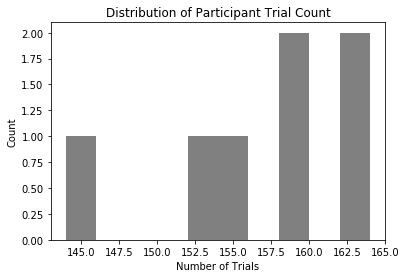

In [28]:
# subselect subjects that have 192 trials (none removed in outlier cleaning)

completeData_subjects = []
cD_distribution = []
all_subjIDs = cleaned_data.subjID.unique()
    
for subj in all_subjIDs:
    subj_df = cleaned_data.loc[cleaned_data['subjID'] == subj]
    count_trials = len(subj_df.index)
    cD_distribution.append(count_trials)
    if count_trials == 156:
        completeData_subjects.append(subj)

print('# of subjs with 156 trials: ',len(completeData_subjects))
print('Average # of trials: ', int(np.mean(cD_distribution)))

plt.hist(cD_distribution, color='gray')
# plt.xticks(np.arange(174, 194, 2))
plt.title('Distribution of Participant Trial Count')
plt.xlabel('Number of Trials')
plt.ylabel('Count')
plt.show()

In [29]:
# remove participants
remove = []
for index, row in cleaned_data.iterrows():
    if row['subjID'] in remove:
        cleaned_data.drop(index, inplace=True)

In [23]:
final_data = cleaned_data.copy(deep=True)

In [31]:
len(final_data.subjID.unique())

7

### Z-Score Depth Estimates and RT 

In [132]:
def zscored_outcomes(df):
    '''
    z-score depth estimates and RTs:
        for each subj calculate their avg and std 
        zscored = (estim - subj avg)/subj std
    '''
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    
    df2_list = []
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj]
        final_subj_df = subj_df.copy(deep=True) # prevent setting with copy warning 
        # Z-Score depth estimates
        average_estim = subj_df["depth_estimate"].mean()
        std_estim = subj_df["depth_estimate"].std()
        subj_depth_estimates = np.array(list(subj_df["depth_estimate"]))
        zscored_subj_depth_estimates = (subj_depth_estimates - average_estim)/std_estim
        final_subj_df.replace(subj_depth_estimates, zscored_subj_depth_estimates, inplace=True)
        # Z-Score RT
        average_RT = subj_df["trial_RT"].mean()
        std_RT = subj_df["trial_RT"].std()
        subj_RTs = np.array(list(subj_df["trial_RT"]))
        zscored_subj_RTs = (subj_RTs - average_RT)/std_RT
        final_subj_df.replace(subj_RTs, zscored_subj_RTs, inplace=True)
        df2_list.append(final_subj_df)
    
    df2 = pd.concat(df2_list)    

    return df2
     

In [133]:
zscored_data = zscored_outcomes(final_data)

In [66]:
# zscored_data

In [134]:
average_depth_estimate = final_data['depth_estimate'].mean()
average_depth_estimate

11.005532565977855

In [39]:
sampled_urls = final_data.url.unique()
# sampled_urls

#### Unit Distribution 

In [40]:
final_subjects = final_data.subjID.unique()
num_feet = 0
num_meters = 0
feet_subjects = []
for subj in final_subjects:
    unit = subj_units[subj]
    if unit == 'feet':
        num_feet += 1
        feet_subjects.append(subj)
    else:
        num_meters += 1

num_feet, num_meters

(4, 3)

Filter data by removing participants that used meters 

In [30]:
# for subj in final_subjects:
#     if subj not in feet_subjects:
#         print(subj)
#         final_data.drop(final_data.loc[final_data['subjID']==subj].index, inplace=True)

In [41]:
len(final_data.subjID.unique())

7

#### Age

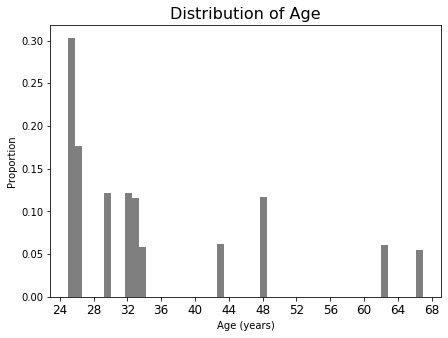

In [27]:
all_ages = final_data['age']
plt.figure(figsize = [7,5])
plt.xticks(np.arange(20,100, 4) ,fontsize=12)
# plt.yticks([])
plt.xlabel('Age (years)')
plt.ylabel('Proportion')
plt.title('Distribution of Age', fontsize=16)
_, bins, _= plt.hist(all_ages, 50, density=1, alpha=0.5, color='black')
plt.show()


In [135]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.anova import AnovaRM

def subject_pivotTable(data, duration):
    """
    Generate pivot tables from data after cleaning and outlier removal 
    Organizes data such that for each rounded actual depth the following is calulated:
    - average depth estimation
    - standard deviation
    - standard error 
    """

    ###### CREATE DF WITH DATA STATISTICS AFTER OUTLIER REMOVAL ######
    avg = pd.pivot_table(data,  values = ["depth_estimate"], columns=['actual_depth'], aggfunc=np.mean)
    avg.reset_index()
    avg_renamed = avg.rename(index={'depth_estimate': 'Average Estimated Depth'})
        
    std = pd.pivot_table(data, values = ["depth_estimate"], columns = ["actual_depth"], aggfunc = np.std)
    #note - std is normalized byN-1 by default (ddof parameter = 1 by default)
    std.reset_index()
    std_renamed = std.rename(index={'depth_estimate': 'Standard Deviation'})
        
    sem = pd.pivot_table(data, values = ["depth_estimate"], columns = ["actual_depth"], aggfunc = 'sem')
    sem.reset_index()
    sem_renamed = sem.rename(index={'depth_estimate': 'Standard Error'})
        
    frames = [avg_renamed, std_renamed, sem_renamed] #list of pivot tables for a given duration
    result = pd.concat(frames) #merge the pivot tables for a given duration 
    result = result.T #transpose 
        
    #Label the data by duration 
    result["Duration"] = duration
    
    return result

def subject_getxy(data):
    """
    Extracts the data from the dataframes to a list format for plotting. 
    """
    x = []
    y = []
    ste = []
    for idx, row in data.iterrows():
        x.append(idx) #idx is the actual depth value 
            
        estim_avg = row["Average Estimated Depth"]
        y.append(estim_avg)
            
        standard_error = row["Standard Error"]
        ste.append(standard_error)
   
    return x, y, ste 


In [136]:
def AnovaRM_subjectData(df, durations):
    """
    Analyze data by each subject 
    Returns list of data by subject
    """
    
    all_subjIDs = df.subjID.unique()
    subj_slopes = {'subjID': [], 'duration': [], 'slope': [], 'age': []}
    subj_intercepts = {'subjID': [], 'duration': [], 'intercept' : [], 'age': []}

    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj] 
        for duration in durations:
            duration_subj_df = subj_df
            duration_subj_pivot = subject_pivotTable(duration_subj_df, duration)
            duration_subj_data = subject_getxy(duration_subj_pivot)

            x = np.array(duration_subj_data[0])
            y = np.array(duration_subj_data[1])
            slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
            subj_slopes['subjID'].append(subj)
            subj_slopes['duration'].append(duration)
            subj_slopes['slope'].append(slope)
            subj_slopes['age'].append(duration_subj_df.age.unique()[0])
            
            subj_intercepts['subjID'].append(subj)
            subj_intercepts['duration'].append(duration)            
            subj_intercepts['intercept'].append(intercept)
            subj_intercepts['age'].append(duration_subj_df.age.unique()[0])
                
    slope_df = pd.DataFrame(data=subj_slopes)
    intercept_df = pd.DataFrame(data=subj_intercepts)
        
    return slope_df, intercept_df


In [45]:
zs_final_data_250 = zscored_data.loc[zscored_data["duration"]  == 250]
zs_final_data_1000 = zscored_data.loc[zscored_data["duration"]  == 1000]

In [137]:
zs_final_data_125 = zscored_data.loc[zscored_data["duration"]  == 125]
# zs_final_data_125

In [46]:
slopes_250, df_intercept_250 = AnovaRM_subjectData(zs_final_data_250, [250])
slopes_1000, df_intercept_1000 = AnovaRM_subjectData(zs_final_data_1000, [1000])

In [138]:
slopes_125, df_intercept_125 = AnovaRM_subjectData(zs_final_data_125, [125])


#### Distribution of Participant Average Estimates

In [47]:
all_subjIDs = zscored_data.subjID.unique()
avgs = []
for subj in all_subjIDs:
    subj_df = zscored_data.loc[zscored_data['subjID'] == subj]
    subj_avg = np.array(subj_df['depth_estimate']).mean()
    avgs.append(subj_avg)
    if subj_avg > 11:
        print(subj)
    
# 9-6-2021_6-48-58_485648.csv
# 9-6-2021_7-13-44_277612.csv
# 9-6-2021_7-48-11_153554.csv

/Users/prachimahableshwarkar/opt/anaconda3/envs/defaultenv/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/prachimahableshwarkar/opt/anaconda3/envs/defaultenv/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/Users/prachimahableshwarkar/opt/anaconda3/envs/defaultenv/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:897: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
/Users/prachimahableshwarkar/opt/anaconda3/envs/defaultenv/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:897: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)


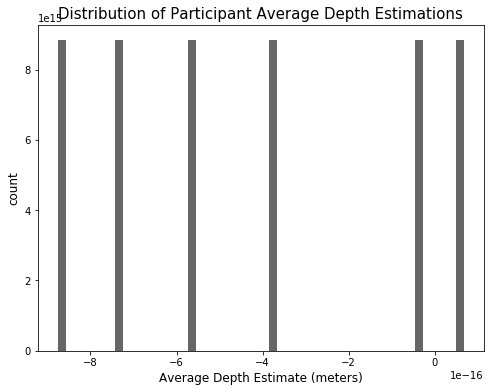

In [48]:
plt.figure(figsize = [8,6])
plt.title("Distribution of Participant Average Depth Estimations", fontsize = 15)
plt.ylabel("count", fontsize = 12)
plt.xlabel("Average Depth Estimate (meters)", fontsize = 12)
_, bins, _ = plt.hist(avgs, 50, density=1, alpha=0.6, color = 'black')
mu, sigma = scipy.stats.norm.fit(avgs)
best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
# plt.plot(bins, best_fit_line, color = 'orange')

plt.show()

### Data split by duration

In [60]:
# data_250ms = zscored_data[zscored_data['duration'] == 250]
# data_1000ms = zscored_data[zscored_data['duration'] == 1000]

# duration_data = [data_250ms, data_1000ms]


In [139]:
data_125ms = zscored_data[zscored_data['duration'] == 125]

duration_data = [data_125ms]

In [40]:
# dest = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/depth_duration_analysis/TAC_data/matched/'
# durations = ['250', '1000']

# for i in range(len(duration_data)):  
#     duration_data[i].to_csv(dest + 'raw_' + durations[i] + '_data.csv' , index=True)
#     normalized_duration_data[i].to_csv(dest + 'normalized_' + durations[i] + '_data.csv' , index=True)

# Individual Target Results


In [140]:
def trial_pivotTable(data):
    """
    Generate pivot tables from data after cleaning and outlier removal 
    Organizes data such that for each individual target (stimulus) the following is calulated:
    - average depth estimation
    - standard deviation
    - standard error 
    """
    
    avg_tables = []
    std_tables = []
    result_tables = []
    ###### CREATE DF WITH DATA STATISTICS AFTER OUTLIER REMOVAL ######
    cond = 0
    for duration in data: #generate pivot tables for data statistics (avg, std, sem)
        actual = pd.pivot_table(duration,  values = ["actual_depth"], columns=['stimulus'], aggfunc=np.mean)
        actual.reset_index()
        actual_renamed = actual.rename(index={'actual_depth': 'Actual Depth'})
        
        avg = pd.pivot_table(duration,  values = ["depth_estimate"], columns=['stimulus'], aggfunc=np.mean)
        avg.reset_index()
        avg_renamed = avg.rename(index={'depth_estimate': 'Average Estimated Depth'})
        
        RT = pd.pivot_table(duration,  values = ["trial_RT"], columns=['stimulus'], aggfunc=np.mean)
        RT.reset_index()
        RT_renamed = RT.rename(index={'trial_RT': 'Average Trial RT'})
        
        std = pd.pivot_table(duration, values = ["depth_estimate"], columns = ["stimulus"], aggfunc = np.std)
        #note - std is normalized byN-1 by default (ddof parameter = 1 by default)
        std.reset_index()
        std_renamed = std.rename(index={'depth_estimate': 'Standard Deviation'})
        
        sem = pd.pivot_table(duration, values = ["depth_estimate"], columns = ["stimulus"], aggfunc = 'sem')
        sem.reset_index()
        sem_renamed = sem.rename(index={'depth_estimate': 'Standard Error'})
        
        frames = [avg_renamed, std_renamed, sem_renamed, actual_renamed, RT_renamed] #list of pivot tables for a given duration
        result = pd.concat(frames) #merge the pivot tables for a given duration 
        result = result.T #transpose 
        result = result.sort_values(by=['Actual Depth'])

        #Label the data by duration based on condition counter (cond)
        if cond == 0:
            result["Duration"] = 250
        if cond == 1:
            result["Duration"] = 1000
        
        avg_tables.append(avg_renamed) #created for reference (not used in code)
        std_tables.append(std_renamed) #created for reference (not used in code)
        result_tables.append(result) #list of results for all durations 
        cond += 1 
        
    
    return result_tables

In [141]:
raw_trial_pivot = trial_pivotTable(duration_data)


In [142]:
# raw_trial_pivot[0]

In [143]:
def trial_getxy(data):
    """
    Extracts the data from the dataframes to a list format for plotting. 
    Args:
        df = [250, 500, 750, 1000]
        These data frames are POST all outlier cleaning. 
        
    Returns:
        actualdepths = [x_250, x_500, x_750, x_1000]
        xs = [list of individual targets]
        ys = [y_250, y_500, y_750, y_100]
        stes = [ste_250, ste_500, ste_750, ste_1000]
        
    """
    xs = []
    ys = []
    stes = []
    stds = []
    actualdepths = []
    trial_RTs = []
    for table in data:
        x = []
        y = []
        ste = []
        std = []
        depths = []
        RT = []
        for idx, row in table.iterrows():
            
            x.append(idx) #idx is the target (stimulus path)
            
            estim_avg = row["Average Estimated Depth"]
            y.append(estim_avg)
            
            standard_error = row["Standard Error"]
            ste.append(standard_error)
            
            depth = row["Actual Depth"]
            depths.append(depth)
            
            standard_deviation = row["Standard Deviation"]
            std.append(standard_deviation)       
            
            reactionTime = row["Average Trial RT"]
            RT.append(reactionTime)  
            
        xs.append(x)
        ys.append(y)
        stes.append(ste)
        actualdepths.append(depths)
        stds.append(std)
        trial_RTs.append(RT)

    return xs, ys, stes, actualdepths, stds, trial_RTs

In [144]:
trial_raw_final = trial_getxy(raw_trial_pivot)


In [145]:
# trial_raw_final


### Raw Data

In [146]:
# trial_plot_data = trial_raw_final

# ## Execute this cell to prep for plotting
# final_x_250 = trial_plot_data[0][0]
# final_y_250 = trial_plot_data[1][0]
# ste_250 = trial_plot_data[2][0]
# stim_250 = trial_plot_data[3][0]
# std_250 = trial_plot_data[4][0]
# RT_250 = trial_plot_data[5][0]

# final_x_1000 = trial_plot_data[0][1]
# final_y_1000 = trial_plot_data[1][1]
# ste_1000 = trial_plot_data[2][1]
# stim_1000 = trial_plot_data[3][1]
# std_1000 = trial_plot_data[4][1]
# RT_1000 = trial_plot_data[5][1]

In [189]:
trial_plot_data = trial_raw_final

## Execute this cell to prep for plotting
final_x_125 = trial_plot_data[0][0]
final_y_125 = trial_plot_data[1][0]
ste_125 = trial_plot_data[2][0]
stim_125 = trial_plot_data[3][0]
std_125 = trial_plot_data[4][0]
RT_125 = trial_plot_data[5][0]

In [172]:
final_stim_250 = np.load('/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/verbal_judgement_analysis/TAC_npy_files/matchedVE/z-scored/final_stim_250.npy')
final_y_250 = np.load('/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/verbal_judgement_analysis/TAC_npy_files/matchedVE/z-scored/final_y_250.npy')
ste_250 = np.load('/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/verbal_judgement_analysis/TAC_npy_files/matchedVE/z-scored/ste_250.npy')


final_stim_1000 = np.load('/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/verbal_judgement_analysis/TAC_npy_files/matchedVE/z-scored/final_stim_1000.npy')
final_y_1000 = np.load('/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/verbal_judgement_analysis/TAC_npy_files/matchedVE/z-scored/final_y_1000.npy')
ste_1000 = np.load('/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/verbal_judgement_analysis/TAC_npy_files/matchedVE/z-scored/ste_1000.npy')

In [197]:
# 125 ms data has fewer images so need to match 250 ms data to the same stimulus order as 125 ms
# there are some images in 125 ms data that dont exist in 250 ms, so need to remove those 

trunc_y_125 = []
trunc_y_250 = []
trunc_y_1000 = []

trunc_ste_125 = []
trunc_ste_250 = []
trunc_ste_1000 = []

for i in range(len(final_x_125)):
    
    try:
        index = list(final_stim_250).index(final_x_125[i])
        y_250 = final_y_250[index]
        y_1000 = final_y_1000[index]
        y_125 = final_y_125[i]

        trunc_y_250.append(y_250)
        trunc_y_1000.append(y_1000)
        trunc_y_125.append(y_125)

        trunc_ste_125.append(ste_125[i]) 
        trunc_ste_250.append(list(ste_250)[index])
        trunc_ste_1000.append(list(ste_1000)[index])
        
    except:
        pass


In [198]:
len(trunc_ste_1000)

156

In [150]:
scipy.stats.pearsonr(trunc_y_125, trunc_y_250)

(0.7567623905880488, 3.116956320610722e-30)

In [151]:
scipy.stats.pearsonr(trunc_y_125, trunc_y_1000)

(0.7227090510628403, 1.739275130706995e-26)

In [152]:
scipy.stats.pearsonr(trunc_y_250, trunc_y_1000)

(0.9438974933698375, 5.391292496703656e-76)

m: [0.17854243]
b: -0.5484719573530512
R-squared:  0.2756678527792752


0.276

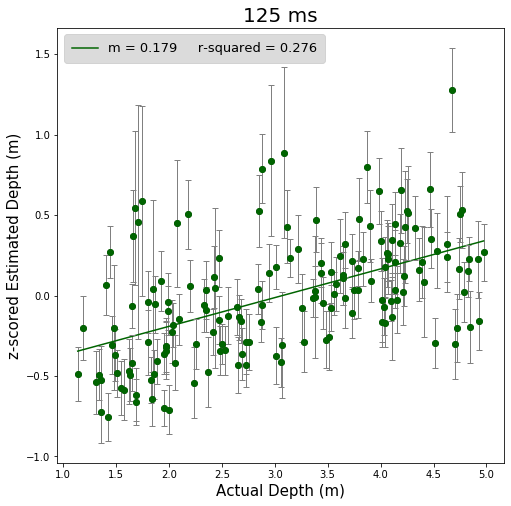

In [255]:
from sklearn.linear_model import LinearRegression

plt.figure(figsize = [8,8])
#run regression
X_125 = np.array(stim_125).reshape(-1,1)
y_125 = final_y_125
reg_125 = LinearRegression().fit(X_125, y_125)

#Generated Predictions
y_predicted_125 = reg_125.predict(X_125)
#Plot Our Actual and Predicted Values
plt.plot(X_125, y_125, 'o', color='black', alpha = 0.5);
plt.plot(X_125,y_predicted_125,color='darkgreen', label = 'm = ' + str(round(reg_125.coef_[0], 3))
         + '     r-squared = ' + str(round(float(reg_125.score(X_125, y_125)), 3)))
plt.title("125 ms", fontsize = 20)
plt.xlabel("Actual Depth (m)", fontsize = 15)
plt.ylabel("z-scored Estimated Depth (m)", fontsize = 15)
# plt.plot(X_125, X_125, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid
plt.errorbar(X_125, y_125, yerr=ste_125, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "darkgreen", mec = "darkgreen", capsize = 3)

legend = plt.legend(loc = 0, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')


#get coefficients and y intercept
print("m: {0}".format(reg_125.coef_))
print("b: {0}".format(reg_125.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_125.score(X_125, y_125))

round(float(reg_125.score(X_125, y_125)), 3)

m: [1.35209909]
b: 0.030369439100524483
R-squared:  0.5726893158085388


0.573

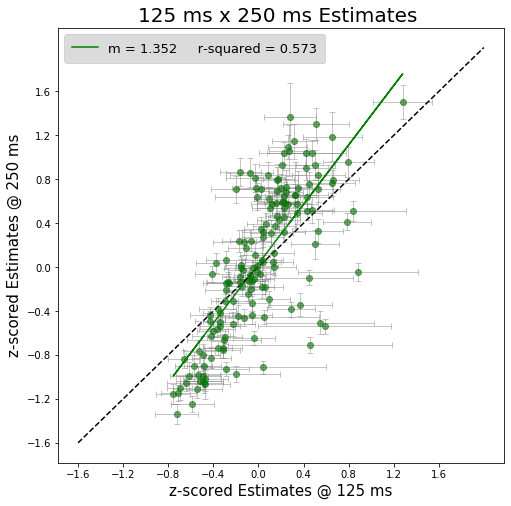

In [260]:
from sklearn.linear_model import LinearRegression

plt.figure(figsize = [8,8])
#run regression
X_125 = np.array(trunc_y_125).reshape(-1,1)
y_125 = trunc_y_250
reg_125 = LinearRegression().fit(X_125, y_125)

#Generated Predictions
y_predicted_125 = reg_125.predict(X_125)
#Plot Our Actual and Predicted Values
plt.plot(X_125, y_125, 'o', color='black', alpha = 0.2);
plt.plot(X_125,y_predicted_125,color='green', label = 'm = ' + str(round(reg_125.coef_[0], 3))
         + '     r-squared = ' + str(round(float(reg_125.score(X_125, y_125)), 3)))
plt.title("125 ms x 250 ms Estimates ", fontsize = 20)
plt.xlabel("z-scored Estimates @ 125 ms", fontsize = 15)
plt.ylabel("z-scored Estimates @ 250 ms", fontsize = 15)
plt.plot([-1.6,2], [-1.6,2], color = 'black',linestyle='--')  # solid
plt.errorbar(X_125, y_125, xerr = trunc_ste_125, yerr= trunc_ste_250, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "green", mec = "green", capsize = 3, alpha=0.45)

legend = plt.legend(loc = 0, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')


plt.xticks(np.arange(-1.6, 2, 0.4))
plt.yticks(np.arange(-1.6, 2, 0.4))

#get coefficients and y intercept
print("m: {0}".format(reg_125.coef_))
print("b: {0}".format(reg_125.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_125.score(X_125, y_125))

round(float(reg_125.score(X_125, y_125)), 3)

m: [1.25045434]
b: 0.03144581576826953
R-squared:  0.522308372488151


0.522

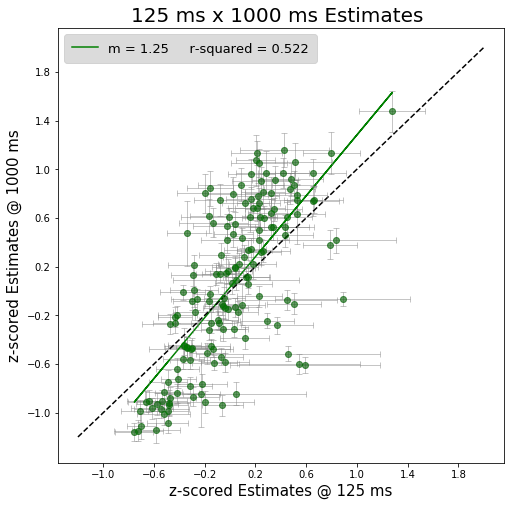

In [261]:
from sklearn.linear_model import LinearRegression

fig = plt.figure(figsize=[8,8])
ax = fig.add_subplot(111)

#run regression
X_125 = np.array(trunc_y_125).reshape(-1,1)
y_125 = trunc_y_1000
reg_125 = LinearRegression().fit(X_125, y_125)

#Generated Predictions
y_predicted_125 = reg_125.predict(X_125)
#Plot Our Actual and Predicted Values
plt.plot(X_125, y_125, 'o', color='black', alpha = 0.3);
plt.plot(X_125,y_predicted_125,color='green', label = 'm = ' + str(round(reg_125.coef_[0], 3))
         + '     r-squared = ' + str(round(float(reg_125.score(X_125, y_125)), 3)))
plt.title("125 ms x 1000 ms Estimates ", fontsize = 20)
plt.xlabel("z-scored Estimates @ 125 ms", fontsize = 15)
plt.ylabel("z-scored Estimates @ 1000 ms", fontsize = 15)
plt.plot([-1.2, 2], [-1.2,2],color = 'black',linestyle='--')  # solid
plt.errorbar(X_125, y_125, xerr = trunc_ste_125, yerr=trunc_ste_1000, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "green", mec = "green", capsize = 3, alpha=0.45)



plt.xticks(np.arange(-1, 2.0, 0.4))
plt.yticks(np.arange(-1, 2.0, 0.4))

# ax.set_aspect('equal')

legend = plt.legend(loc = 0, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')


#get coefficients and y intercept
print("m: {0}".format(reg_125.coef_))
print("b: {0}".format(reg_125.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_125.score(X_125, y_125))

round(float(reg_125.score(X_125, y_125)), 3)

m: [0.91407156]
b: 0.0037345509940465635
R-squared:  0.8909424779898623


0.891

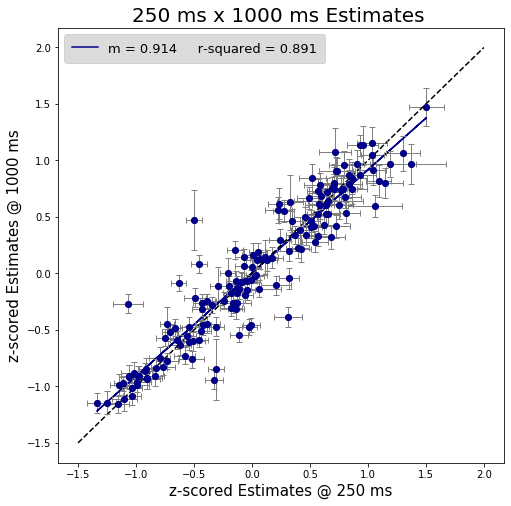

In [259]:
from sklearn.linear_model import LinearRegression

plt.figure(figsize = [8,8])
#run regression
X_125 = np.array(trunc_y_250).reshape(-1,1)
y_125 = trunc_y_1000
reg_125 = LinearRegression().fit(X_125, y_125)

#Generated Predictions
y_predicted_125 = reg_125.predict(X_125)
#Plot Our Actual and Predicted Values
plt.plot(X_125, y_125, 'o', color='black', alpha = 0.5);
plt.plot(X_125,y_predicted_125,color='darkblue', label = 'm = ' + str(round(reg_125.coef_[0], 3))
         + '     r-squared = ' + str(round(float(reg_125.score(X_125, y_125)), 3)))
plt.title("250 ms x 1000 ms Estimates ", fontsize = 20)
plt.xlabel("z-scored Estimates @ 250 ms", fontsize = 15)
plt.ylabel("z-scored Estimates @ 1000 ms", fontsize = 15)
plt.plot([-1.5,2], [-1.5,2],  color = 'black',linestyle='--')  # solid
plt.errorbar(X_125, y_125, xerr = trunc_ste_250, yerr=trunc_ste_1000, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "darkblue", mec = "darkblue", capsize = 3)

legend = plt.legend(loc = 0, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')


#get coefficients and y intercept
print("m: {0}".format(reg_125.coef_))
print("b: {0}".format(reg_125.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_125.score(X_125, y_125))

round(float(reg_125.score(X_125, y_125)), 3)

m: [0.90065016]
b: -0.0016433254585005164
R-squared:  0.8936223617565993


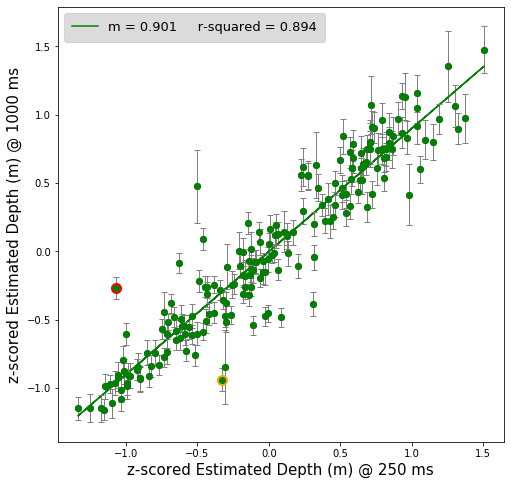

In [94]:
from sklearn.linear_model import LinearRegression

plt.figure(figsize = [8,8])
#run regression
X_1000 = np.array(final_y_250).reshape(-1,1)
y_1000 = final_y_1000
reg_1000 = LinearRegression().fit(X_1000, y_1000)

#Generated Predictions
y_predicted_1000 = reg_1000.predict(X_1000)
#Plot Our Actual and Predicted Values
plt.plot(X_1000, y_1000, 'o', color='black', alpha = 0.7);
plt.plot(X_1000,y_predicted_1000,color='green', label = 'm = ' + str(round(reg_1000.coef_[0], 3))
         + '     r-squared = ' + str(round(float(reg_1000.score(X_1000, y_1000)), 3)))

# plt.title("1000 ms", fontsize = 20)
plt.xlabel("z-scored Estimated Depth (m) @ 250 ms", fontsize = 15)
plt.ylabel("z-scored Estimated Depth (m) @ 1000 ms", fontsize = 15)
# plt.plot(X_1000, X_1000, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid
plt.errorbar(X_1000, y_1000, yerr=ste_1000, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "green", mec = "green", capsize = 3)


legend = plt.legend(loc = 0, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')

plt.plot(final_y_250[64], final_y_1000[64], marker="o", markersize = 10, markeredgecolor="red", markerfacecolor="red")

plt.plot(final_y_250[61], final_y_1000[61], marker="o", markersize = 10, markeredgecolor="orange", markerfacecolor="orange")

#get coefficients and y intercept
print("m: {0}".format(reg_1000.coef_))
print("b: {0}".format(reg_1000.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_1000.score(X_1000, y_1000))

In [88]:
indices = [idx for idx,val in enumerate(final_y_250) if -0.4 < val < -0.25]
indices

[17, 37, 53, 61, 65, 71, 74, 83, 95, 99, 105, 142]

In [92]:
final_y_250[61], final_y_1000[61], final_x_250[61]

(-0.32656530342261036,
 -0.9412279652742374,
 'depth_duration_stimuli/000749_2014-06-08_21-55-06_260595134347_rgbf000070-resize_2/000749_2014-06-08_21-55-06_260595134347_rgbf000070-resize_2-target.png')

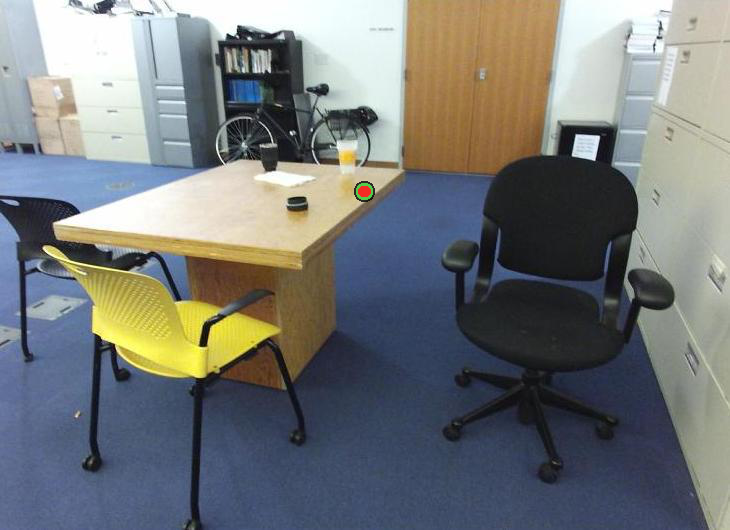

In [87]:
final_y_250[64], final_y_1000[64], final_x_250[64]

(-1.06730995006498,
 -0.2685806946332364,
 'depth_duration_stimuli/000522_2014-06-08_13-35-06_260595134347_rgbf000244-resize_1/000522_2014-06-08_13-35-06_260595134347_rgbf000244-resize_1-target.png')

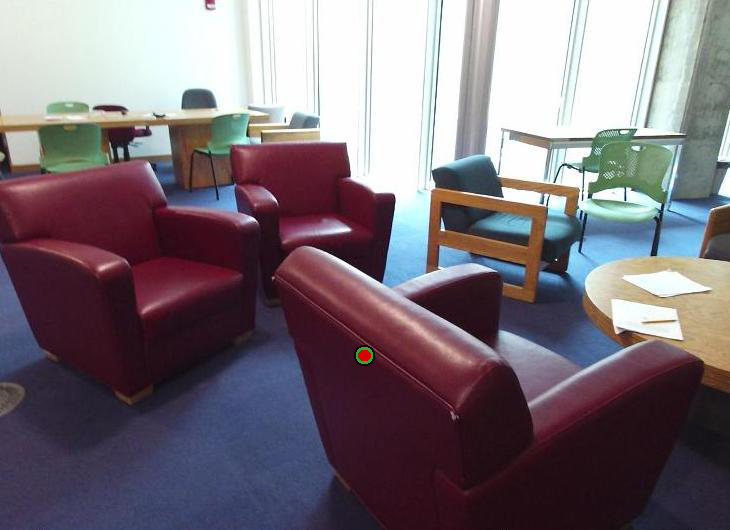

m: [0.15411759]
b: -0.0002135859513755244
R-squared:  0.33881275963473884


0.339

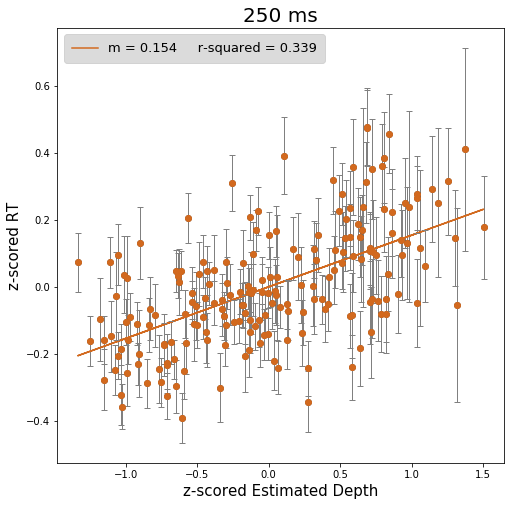

In [50]:
from sklearn.linear_model import LinearRegression

plt.figure(figsize = [8,8])
#run regression
X_250 = np.array(final_y_250).reshape(-1,1)
y_250 = RT_250
reg_250 = LinearRegression().fit(X_250, y_250)

#Generated Predictions
y_predicted_250 = reg_250.predict(X_250)
#Plot Our Actual and Predicted Values
plt.plot(X_250, y_250, 'o', color='black', alpha = 0.5);
plt.plot(X_250,y_predicted_250,color='chocolate', label = 'm = ' + str(round(reg_250.coef_[0], 3))
         + '     r-squared = ' + str(round(float(reg_250.score(X_250, y_250)), 3)))
plt.title("250 ms", fontsize = 20)
plt.xlabel("z-scored Estimated Depth", fontsize = 15)
plt.ylabel("z-scored RT", fontsize = 15)
plt.errorbar(X_250, y_250, yerr=ste_250, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "chocolate", mec = "chocolate", capsize = 3)

legend = plt.legend(loc = 0, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')


#get coefficients and y intercept
print("m: {0}".format(reg_250.coef_))
print("b: {0}".format(reg_250.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_250.score(X_250, y_250))

round(float(reg_250.score(X_250, y_250)), 3)

m: [0.20984501]
b: -4.1906640186849904e-05
R-squared:  0.4386643727838815


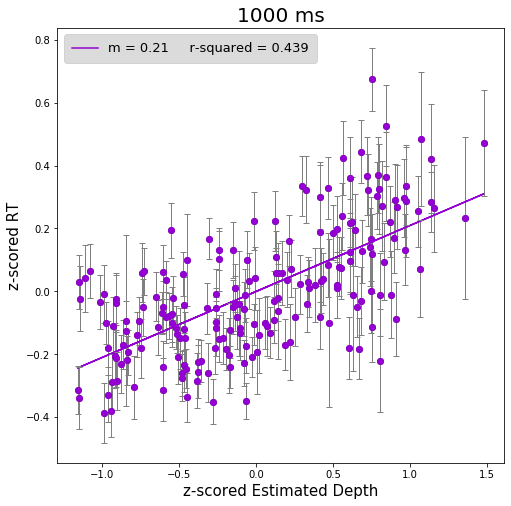

In [51]:
from sklearn.linear_model import LinearRegression

plt.figure(figsize = [8,8])
#run regression
X_1000 = np.array(final_y_1000).reshape(-1,1)
y_1000 = RT_1000
reg_1000 = LinearRegression().fit(X_1000, y_1000)

#Generated Predictions
y_predicted_1000 = reg_1000.predict(X_1000)
#Plot Our Actual and Predicted Values
plt.plot(X_1000, y_1000, 'o', color='black', alpha = 0.7);
plt.plot(X_1000,y_predicted_1000,color='darkviolet', label = 'm = ' + str(round(reg_1000.coef_[0], 3))
         + '     r-squared = ' + str(round(float(reg_1000.score(X_1000, y_1000)), 3)))

plt.title("1000 ms", fontsize = 20)
plt.xlabel("z-scored Estimated Depth", fontsize = 15)
plt.ylabel("z-scored RT", fontsize = 15)
# plt.plot(X_1000, X_1000, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid
plt.errorbar(X_1000, y_1000, yerr=ste_1000, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "darkviolet", mec = "darkviolet", capsize = 3)


legend = plt.legend(loc = 0, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')


#get coefficients and y intercept
print("m: {0}".format(reg_1000.coef_))
print("b: {0}".format(reg_1000.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_1000.score(X_1000, y_1000))

In [54]:
n_destpath = '/Users/prachi/Documents/depth_duration/verbal_judgement_analysis/TAC_npy_files/matchedVE/z-scored/'

with open(n_destpath + 'X_250.npy', 'wb') as f:
    np.save(f, X_250)
with open(n_destpath + 'final_y_250.npy', 'wb') as f:
    np.save(f, final_y_250)
    
with open(n_destpath + 'X_1000.npy', 'wb') as f:
    np.save(f, X_1000)
with open(n_destpath + 'final_y_1000.npy', 'wb') as f:
    np.save(f, final_y_1000)

with open(n_destpath + 'std_250.npy', 'wb') as f:
    np.save(f, std_250)
    
with open(n_destpath + 'std_1000.npy', 'wb') as f:
    np.save(f, std_1000)
    
with open(n_destpath + 'ste_250.npy', 'wb') as f:
    np.save(f, ste_250)
    
with open(n_destpath + 'ste_1000.npy', 'wb') as f:
    np.save(f, ste_1000)

with open(n_destpath + 'final_stim_250.npy', 'wb') as f:
    np.save(f, final_x_250)

with open(n_destpath + 'final_stim_1000.npy', 'wb') as f:
    np.save(f, final_x_1000)

## One-Way Repeated Measures ANOVA

https://statistics.laerd.com/statistical-guides/repeated-measures-anova-statistical-guide.php

IV conditions: Duration - 250, 500, 750, 1000

IV: Actual Depth

DV: Depth Estimate 

H0: µ1 = µ2 = µ3 = … = µk where µ = population mean and k = number of related groups. 

HA: at least two means are significantly different

In [78]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.anova import AnovaRM

def subject_pivotTable(data, duration):
    """
    Generate pivot tables from data after cleaning and outlier removal 
    Organizes data such that for each rounded actual depth the following is calulated:
    - average depth estimation
    - standard deviation
    - standard error 
    """

    ###### CREATE DF WITH DATA STATISTICS AFTER OUTLIER REMOVAL ######
    avg = pd.pivot_table(data,  values = ["depth_estimate"], columns=['actual_depth'], aggfunc=np.mean)
    avg.reset_index()
    avg_renamed = avg.rename(index={'depth_estimate': 'Average Estimated Depth'})
        
    std = pd.pivot_table(data, values = ["depth_estimate"], columns = ["actual_depth"], aggfunc = np.std)
    #note - std is normalized byN-1 by default (ddof parameter = 1 by default)
    std.reset_index()
    std_renamed = std.rename(index={'depth_estimate': 'Standard Deviation'})
        
    sem = pd.pivot_table(data, values = ["depth_estimate"], columns = ["actual_depth"], aggfunc = 'sem')
    sem.reset_index()
    sem_renamed = sem.rename(index={'depth_estimate': 'Standard Error'})
        
    frames = [avg_renamed, std_renamed, sem_renamed] #list of pivot tables for a given duration
    result = pd.concat(frames) #merge the pivot tables for a given duration 
    result = result.T #transpose 
        
    #Label the data by duration 
    result["Duration"] = duration
    
    return result

def subject_getxy(data):
    """
    Extracts the data from the dataframes to a list format for plotting. 
    """
    x = []
    y = []
    ste = []
    for idx, row in data.iterrows():
        x.append(idx) #idx is the actual depth value 
            
        estim_avg = row["Average Estimated Depth"]
        y.append(estim_avg)
            
        standard_error = row["Standard Error"]
        ste.append(standard_error)
   
    return x, y, ste 

def subjectData(df):
    """
    Analyze data by each subject 
    Returns list of data by subject
    """
    
    all_subjIDs = df.subjID.unique()
    
    subj_slopes_intercepts = {'subjID': [], 'duration': [], 'block': [], 'slope': [], 'intercept' : []}

    durations = [125]
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj] 
        block1 = subj_df.loc[subj_df['trial'] < 49]
        temp_block2 = subj_df.loc[subj_df['trial'] <= 96]
        block2 = temp_block2.loc[temp_block2['trial'] >= 49]
        temp_block3 = subj_df.loc[subj_df['trial'] <= 144]
        block3 = temp_block3.loc[temp_block3['trial'] > 96]
        block4 = subj_df.loc[subj_df['trial'] >= 145]
        blocks = [block1, block2, block3, block4]
        
        num_block = 1
        for block in blocks:
            for duration in durations:
                block_duration_subj_df = block.loc[block["duration"]  == duration]
                block_duration_subj_pivot = subject_pivotTable(block_duration_subj_df, duration)
                block_duration_subj_data = subject_getxy(block_duration_subj_pivot)

                x = np.array(block_duration_subj_data[0])
                y = np.array(block_duration_subj_data[1])
                slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
                subj_slopes_intercepts['subjID'].append(subj)
                subj_slopes_intercepts['duration'].append(duration)
                subj_slopes_intercepts['block'].append(num_block)
                subj_slopes_intercepts['slope'].append(slope)
                subj_slopes_intercepts['intercept'].append(intercept)
                
            num_block += 1

    block_duration_df = pd.DataFrame(data=subj_slopes_intercepts)
        
    return block_duration_df  


In [79]:
subject_duration_block_slopes_intercepts = subjectData(final_data)


In [80]:
subject_duration_block_slopes_intercepts

,subjID,duration,block,slope,intercept
0,995624,125,1,-0.277752,5.020628
1,995624,125,2,-0.852195,6.617150
2,995624,125,3,-0.812200,7.029272
3,995624,125,4,-0.076713,3.997290
4,741768,125,1,0.130154,0.275036
...,...,...,...,...,...
75,704748,125,4,1.035722,-0.930818
76,843913,125,1,0.034941,2.260183
77,843913,125,2,0.851775,2.404054
78,843913,125,3,0.606076,1.989685


In [156]:
def AnovaRM_subjectData(df):
    """
    Analyze data by each subject 
    Returns list of data by subject
    """
    
    all_subjIDs = df.subjID.unique()
    
    subj_slopes = {'subjID': [], 'duration': [], 'slope': []}
    subj_intercepts = {'subjID': [], 'duration': [], 'intercept' : []}

    durations = [125]
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj] 

        for duration in durations:
            duration_subj_df = subj_df.loc[subj_df["duration"]  == duration]
            duration_subj_pivot = subject_pivotTable(duration_subj_df, duration)
            duration_subj_data = subject_getxy(duration_subj_pivot)

            x = np.array(duration_subj_data[0])
            y = np.array(duration_subj_data[1])
            slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
            subj_slopes['subjID'].append(subj)
            subj_slopes['duration'].append(duration)
            subj_slopes['slope'].append(slope)
            
            subj_intercepts['subjID'].append(subj)
            subj_intercepts['duration'].append(duration)            
            subj_intercepts['intercept'].append(intercept)
                
    slope_df = pd.DataFrame(data=subj_slopes)
    intercept_df = pd.DataFrame(data=subj_intercepts)
        
    return slope_df, intercept_df

In [157]:
df_slope, df_intercept = AnovaRM_subjectData(final_data)

df_slope

,subjID,duration,slope
0,995624,125,-0.605503
1,741768,125,0.101169
2,267485,125,0.784339
3,384789,125,0.128721
4,357469,125,-0.959995
5,862605,125,1.056323
6,876081,125,0.499721
7,199911,125,-0.039477
8,243394,125,0.669602
9,919852,125,-0.048649


In [158]:
slopes_125 = df_slope.loc[df_slope['duration'] == 125]


# slopes_250 = df_slope.loc[df_slope['duration'] == 250]
# slopes_500 = df_slope.loc[df_slope['duration'] == 500]
# slopes_750 = df_slope.loc[df_slope['duration'] == 750]
# slopes_1000 = df_slope.loc[df_slope['duration'] == 1000]

In [159]:
def ANCOVA_subjectData(df):
    """
    Analyze data by each subject 
    Returns list of data by subject
    """
    
    all_subjIDs = df.subjID.unique()
    
    subj_slopes = {'subjID': [], 'duration': [], 'slope': [], 'age': []}
    subj_intercepts = {'subjID': [], 'duration': [], 'intercept' : [], 'age': []}

    durations = [125]
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj] 

        for duration in durations:
            duration_subj_df = subj_df.loc[subj_df["duration"]  == duration]
            duration_subj_pivot = subject_pivotTable(duration_subj_df, duration)
            duration_subj_data = subject_getxy(duration_subj_pivot)
            
            x = np.array(duration_subj_data[0])
            y = np.array(duration_subj_data[1])
            slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
            subj_slopes['subjID'].append(subj)
            subj_slopes['duration'].append(duration)
            subj_slopes['slope'].append(slope)
            subj_slopes['age'].append(duration_subj_df.age.unique()[0])
            
            subj_intercepts['subjID'].append(subj)
            subj_intercepts['duration'].append(duration)            
            subj_intercepts['intercept'].append(intercept)
            subj_intercepts['age'].append(duration_subj_df.age.unique()[0])


                
    slope_df = pd.DataFrame(data=subj_slopes)
    intercept_df = pd.DataFrame(data=subj_intercepts)
        
    return slope_df, intercept_df

In [160]:
df_age_slope, df_age_intercept = ANCOVA_subjectData(final_data)

In [161]:
df_age_slope_125 = df_age_slope.loc[df_age_slope['duration'] == 125] 
df_age_slope_125_mean = df_age_slope_125.groupby('age').mean()

In [254]:
# df_age_slope_250 = df_age_slope.loc[df_age_slope['duration'] == 250] 
# df_age_slope_250_mean = df_age_slope_250.groupby('age').mean()

# df_age_slope_500 = df_age_slope.loc[df_age_slope['duration'] == 500] 
# df_age_slope_500_mean = df_age_slope_500.groupby('age').mean()

# df_age_slope_750 = df_age_slope.loc[df_age_slope['duration'] == 750] 
# df_age_slope_750_mean = df_age_slope_750.groupby('age').mean()

# df_age_slope_1000 = df_age_slope.loc[df_age_slope['duration'] == 1000] 
# df_age_slope_1000_mean = df_age_slope_1000.groupby('age').mean()

In [90]:
df_age_slope

,subjID,duration,slope,age
0,995624,125,-0.605503,48
1,741768,125,0.101169,48
2,267485,125,0.784339,43
3,384789,125,0.128721,62
4,357469,125,-0.959995,25
5,862605,125,1.056323,32
6,876081,125,0.499721,26
7,199911,125,-0.039477,30
8,243394,125,0.669602,34
9,919852,125,-0.048649,32


0.0327577864551862


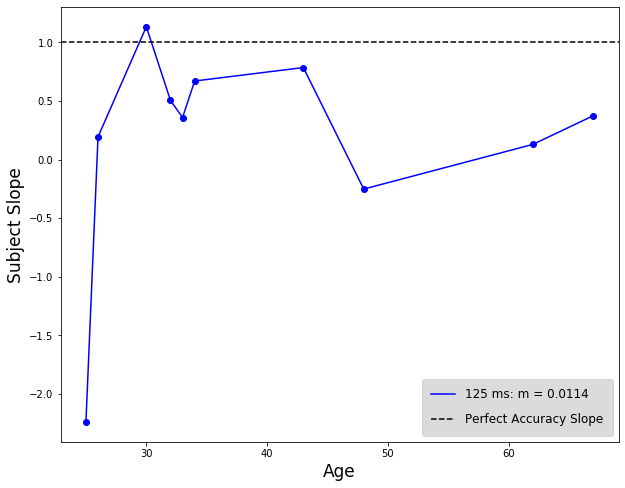

In [162]:
plt.figure(figsize = ([10, 8]))
# plt.xticks(np.arange(20, 80, 5), fontsize = 13)
# plt.yticks(np.arange(0, 1.8, 0.2))
plt.xlabel("Age", fontsize = 17)
plt.ylabel("Subject Slope", fontsize = 17)

ages = df_age_slope_125_mean.index

slope_125, intercept_125, r_value_125, p_value_125, std_err_125 = stats.linregress(ages, df_age_slope_125_mean['slope'])
plt.plot(ages, df_age_slope_125_mean['slope'], label = '125 ms: m = ' + str(round(slope_125, 4)), color = "blue")
plt.plot(df_age_slope_125_mean['slope'], 'o', color = "blue")
print(r_value_125 **2)


# ages = df_age_slope_250_mean.index

# slope_250, intercept_250, r_value_250, p_value_250, std_err_250 = stats.linregress(ages, df_age_slope_250_mean['slope'])
# plt.plot(ages, df_age_slope_250_mean['slope'], label = '250 ms: m = ' + str(round(slope_250, 4)), color = "blue")
# # plt.plot(ages, intercept_250 + slope_250*ages, 'r', color = "blue")
# print(r_value_250 **2)

# slope_500, intercept_500, r_value_500, p_value_500, std_err_500 = stats.linregress(ages, df_age_slope_500_mean['slope'])
# plt.plot(ages, df_age_slope_500_mean['slope'], label = '500 ms: m = ' + str(round(slope_500, 4)), color = "orange")
# # plt.plot(ages, intercept_500 + slope_500*ages, 'r',  color = "orange")
# print(r_value_500 **2)

# slope_750, intercept_750, r_value_750, p_value_750, std_err_750 = stats.linregress(ages, df_age_slope_750_mean['slope'])
# plt.plot(ages, df_age_slope_750_mean['slope'], label = '750 ms: m = ' + str(round(slope_750, 4)), color = "green")
# # plt.plot(ages, intercept_750 + slope_750*ages, 'r', color = "green")
# print(r_value_750 **2)

# slope_1000, intercept_1000, r_value_1000, p_value_1000, std_err_1000 = stats.linregress(ages, df_age_slope_1000_mean['slope'])
# plt.plot(ages, df_age_slope_1000_mean['slope'], label = '1000 ms: m = ' + str(round(slope_1000, 4)), color = "purple")
# # plt.plot(ages, intercept_1000 + slope_1000*ages, 'r',  color = "purple")
# print(r_value_1000 **2)

plt.axhline(y=1, color = 'black',linestyle='--', label = "Perfect Accuracy Slope")


legend = plt.legend(loc = 0, fontsize = 12, borderpad = 0.8, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')

In [93]:
# norm_df_age_slope, norm_df_age_intercept = ANCOVA_subjectData(normalized_data)

In [258]:
# df_age_slope_250 = norm_df_age_slope.loc[df_age_slope['duration'] == 250] 
# df_age_slope_250_mean = df_age_slope_250.groupby('age').mean()

# df_age_slope_500 = norm_df_age_slope.loc[df_age_slope['duration'] == 500] 
# df_age_slope_500_mean = df_age_slope_500.groupby('age').mean()

# df_age_slope_750 = norm_df_age_slope.loc[df_age_slope['duration'] == 750] 
# df_age_slope_750_mean = df_age_slope_750.groupby('age').mean()

# df_age_slope_1000 = norm_df_age_slope.loc[df_age_slope['duration'] == 1000] 
# df_age_slope_1000_mean = df_age_slope_1000.groupby('age').mean()

https://pingouin-stats.org/generated/pingouin.ancova.html

In [94]:
from pingouin import ancova, read_dataset

print("DV: Slope")
ancova(data=df_age_slope, dv='slope', covar='age', between='duration')

DV: Slope


/Users/prachimahableshwarkar/opt/anaconda3/envs/defaultenv/lib/python3.7/site-packages/pingouin/parametric.py:990: RuntimeWarning: invalid value encountered in double_scalars
  msbetween = ssbetween / ddof1
/Users/prachimahableshwarkar/opt/anaconda3/envs/defaultenv/lib/python3.7/site-packages/pingouin/parametric.py:1683: RuntimeWarning: invalid value encountered in double_scalars
  ms_b = ss_b / df_b


,Source,SS,DF,F,p-unc,np2
0,duration,0.000000,0,NaN,NaN,0.000000
1,age,3.648470,1,0.516881,0.481405,0.027914
2,Residual,127.055209,18,NaN,NaN,NaN


/Users/prachimahableshwarkar/opt/anaconda3/envs/defaultenv/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.10, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [260]:
print("DV: Intercept")
ancova(data=df_age_intercept, dv='intercept', covar='age', between='duration')

DV: Intercept


,Source,SS,DF,F,p-unc,np2
0,duration,7.346442,3,1.249135,0.290925,0.005272
1,age,0.358100,1,0.182666,0.669222,0.000258
2,Residual,1386.008225,707,NaN,NaN,NaN


In [261]:
print("DV: Normalized Slope")
ancova(data=norm_df_age_slope, dv='slope', covar='age', between='duration')

DV: Normalized Slope


,Source,SS,DF,F,p-unc,np2
0,duration,0.427577,3,9.636678,0.000003,0.039285
1,age,0.012989,1,0.878212,0.349012,0.001241
2,Residual,10.456472,707,NaN,NaN,NaN


In [262]:
print("DV: Normalized Intercept")
ancova(data=norm_df_age_intercept, dv='intercept', covar='age', between='duration')

DV: Normalized Intercept


,Source,SS,DF,F,p-unc,np2
0,duration,1.768417,3,4.484535,0.003962,0.018674
1,age,0.112267,1,0.854094,0.355712,0.001207
2,Residual,92.932050,707,NaN,NaN,NaN


0.08689035692695636
0.040571521546707075
0.0014183360809096404
0.0003806209655432029


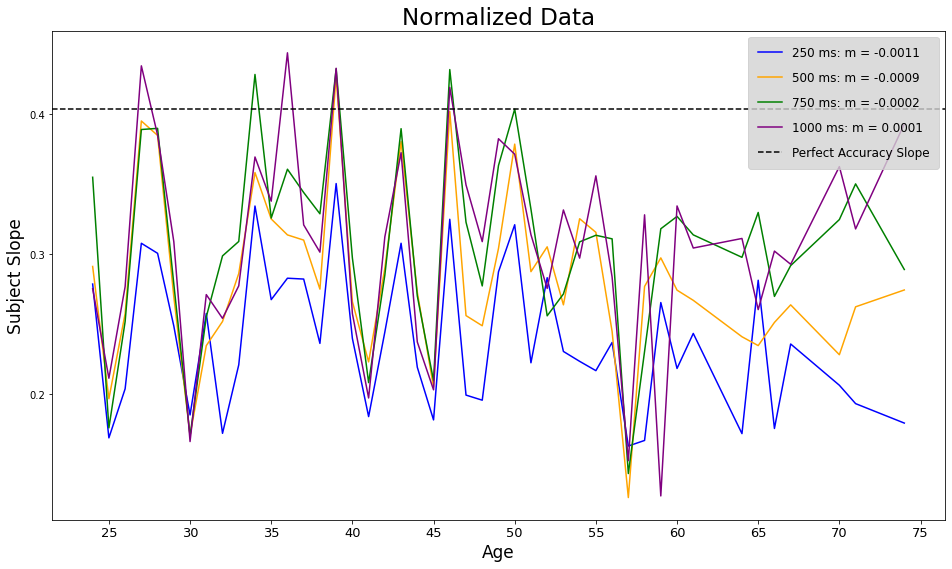

In [263]:
plt.figure(figsize = [16, 9])
plt.xticks(np.arange(20, 80, 5), fontsize = 13)
plt.yticks(np.arange(0, 1.8, 0.1))
plt.xlabel("Age", fontsize = 17)
plt.ylabel("Subject Slope", fontsize = 17)

ages = df_age_slope_250_mean.index

slope_250, intercept_250, r_value_250, p_value_250, std_err_250 = stats.linregress(ages, df_age_slope_250_mean['slope'])
plt.plot(ages, df_age_slope_250_mean['slope'], label = '250 ms: m = ' + str(round(slope_250, 4)), color = "blue")
# plt.plot(ages, intercept_250 + slope_250*ages, 'r', color = "blue")
print(r_value_250 **2)

slope_500, intercept_500, r_value_500, p_value_500, std_err_500 = stats.linregress(ages, df_age_slope_500_mean['slope'])
plt.plot(ages, df_age_slope_500_mean['slope'], label = '500 ms: m = ' + str(round(slope_500, 4)), color = "orange")
# plt.plot(ages, intercept_500 + slope_500*ages, 'r',  color = "orange")
print(r_value_500 **2)

slope_750, intercept_750, r_value_750, p_value_750, std_err_750 = stats.linregress(ages, df_age_slope_750_mean['slope'])
plt.plot(ages, df_age_slope_750_mean['slope'], label = '750 ms: m = ' + str(round(slope_750, 4)), color = "green")
# plt.plot(ages, intercept_750 + slope_750*ages, 'r', color = "green")
print(r_value_750 **2)

slope_1000, intercept_1000, r_value_1000, p_value_1000, std_err_1000 = stats.linregress(ages, df_age_slope_1000_mean['slope'])
plt.plot(ages, df_age_slope_1000_mean['slope'], label = '1000 ms: m = ' + str(round(slope_1000, 4)), color = "purple")
# plt.plot(ages, intercept_1000 + slope_1000*ages, 'r',  color = "purple")
print(r_value_1000 **2)

plt.axhline(y=1/average_depth_estimate, color = 'black',linestyle='--', label = "Perfect Accuracy Slope")

plt.title("Normalized Data", fontsize = 23)
legend = plt.legend(loc = 0, fontsize = 12, borderpad = 0.8, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')